# Notebook 2: Forecasting and Clustering Analysis

# Overview
This notebook extends the analysis by applying forecasting and clustering techniques to Ireland’s energy import dependency data.

# Key Tasks
- Prepare time-series data for forecasting
- Apply ARIMA-based forecasting to Ireland’s import dependency
- Group European countries using clustering techniques
- Visualise cluster structures using centroid profiles and PCA

# Outputs
- Forecast plots saved to the `figures/` directory
- Clustering visualisations saved to the `figures/` directory
- Cluster assignments saved to `data/processed/clusters.csv`

The analysis in this notebook provides structural and forward-looking insights to complement historical and statistical findings.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

plt.rcParams["figure.figsize"] = (10,5)

PROCESSED = Path("../data/processed"); PROCESSED.mkdir(exist_ok=True)
FIGS = Path("../figures"); FIGS.mkdir(exist_ok=True)

def save_fig(name: str):
    plt.tight_layout()
    plt.savefig(FIGS / f"{name}.png", dpi=300)


In [6]:
df_import = pd.read_csv(PROCESSED/"import_dependency_clean.csv")
assert {"geo","year","value"}.issubset(df_import.columns)


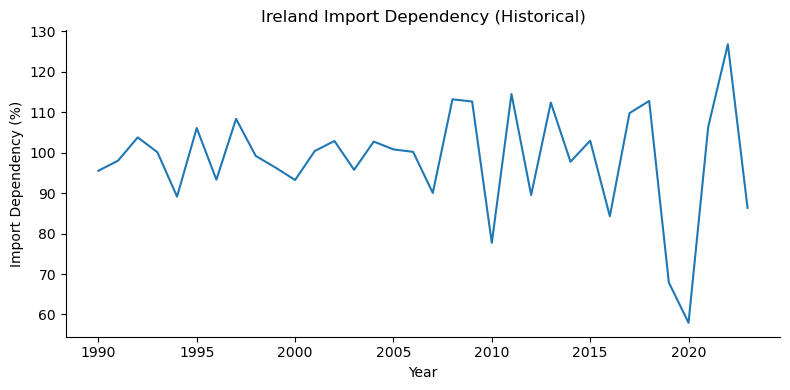

/Users/arjun/miniconda/miniconda3/envs/MSC_DA_CA2/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


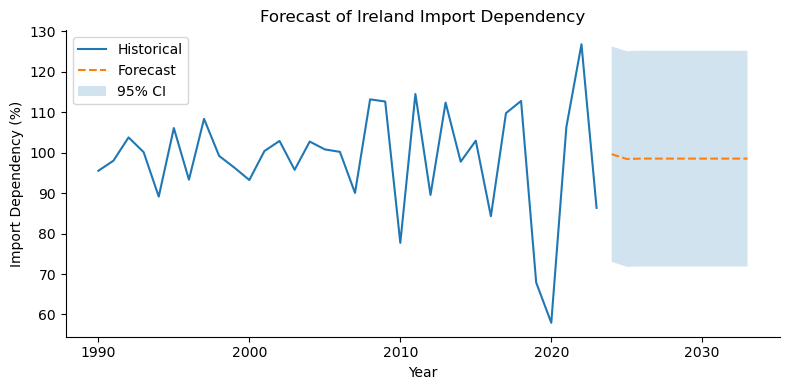

In [7]:

ie = (df_import[df_import["geo"]=="IE"][["year","value"]]
      .dropna()
      .groupby("year", as_index=False)["value"].mean()
      .sort_values("year"))


years_full = np.arange(int(ie["year"].min()), int(ie["year"].max())+1)
hist = pd.Series(ie["value"].values, index=ie["year"].astype(int)).reindex(years_full).astype(float)
hist = hist.interpolate(limit_direction="both")
ts = hist.copy()
ts.index = pd.PeriodIndex(ts.index, freq="Y")

plt.figure(figsize=(8, 4))
plt.plot(ts.index.year, ts.values)
plt.title("Ireland Import Dependency (Historical)")
plt.xlabel("Year"); plt.ylabel("Import Dependency (%)")
for s in ["top","right"]: plt.gca().spines[s].set_visible(False)
plt.grid(False)


save_fig("forecast_ie_historical")

plt.show()
plt.close()


fit = ARIMA(ts, order=(1,1,1)).fit()
fc = fit.get_forecast(steps=10)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

df_forecast = pd.DataFrame({
    "year": fc_mean.index.year,
    "forecast": fc_mean.values,
    "lower": fc_ci.iloc[:,0].values,
    "upper": fc_ci.iloc[:,1].values
})


plt.figure(figsize=(8, 4))
plt.plot(ts.index.year, ts.values, label="Historical")
plt.plot(df_forecast["year"], df_forecast["forecast"], "--", label="Forecast")
plt.fill_between(df_forecast["year"], df_forecast["lower"], df_forecast["upper"], alpha=0.2, label="95% CI")
plt.title("Forecast of Ireland Import Dependency")
plt.xlabel("Year"); plt.ylabel("Import Dependency (%)")
plt.legend()
for s in ["top","right"]: plt.gca().spines[s].set_visible(False)
plt.grid(False)


save_fig("forecast_ie_arima")

plt.show()
plt.close()


df_forecast.to_csv(PROCESSED/"forecast_ie.csv", index=False)


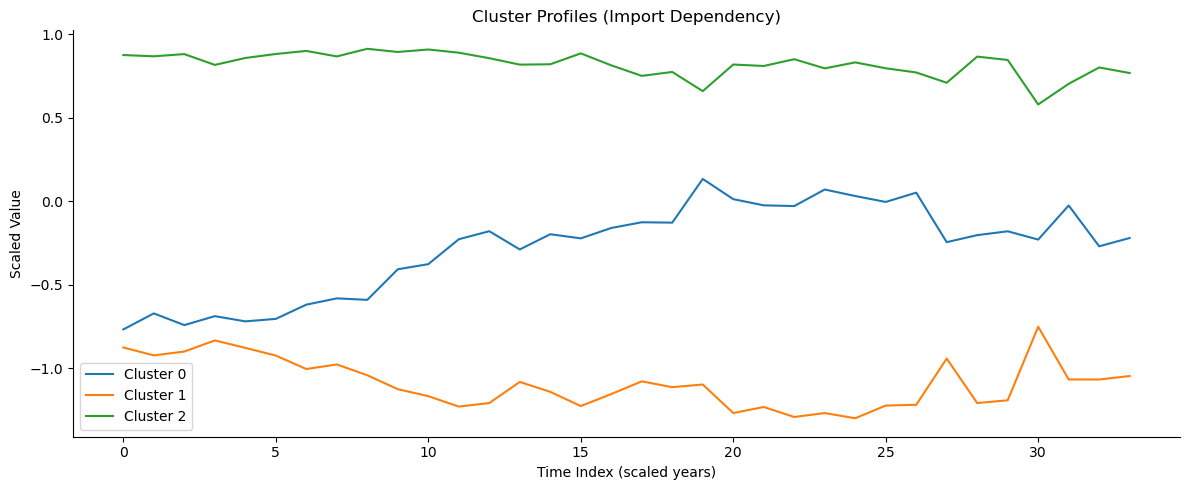

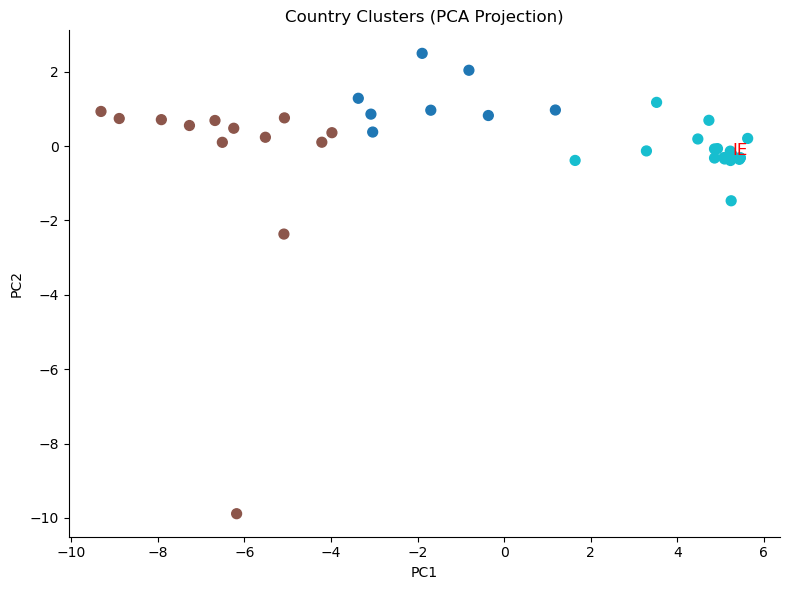

In [8]:

pivot = df_import.pivot_table(index="geo", columns="year", values="value")


pivot = pivot.loc[:, pivot.count() >= 15]   
pivot = pivot[pivot.count(axis=1) >= 10]    


pivot = pivot.apply(lambda r: r.fillna(r.mean()), axis=1)
pivot = pivot.fillna(pivot.mean())
pivot = pivot.dropna(axis=0).dropna(axis=1)


X = StandardScaler().fit_transform(pivot)
kmeans = KMeans(n_clusters=3, random_state=42)
pivot["cluster"] = kmeans.fit_predict(X)


centroids = kmeans.cluster_centers_

plt.figure(figsize=(12, 5))
for i, c in enumerate(centroids):
    plt.plot(c, label=f"Cluster {i}")

plt.title("Cluster Profiles (Import Dependency)")
plt.xlabel("Time Index (scaled years)")
plt.ylabel("Scaled Value")
plt.legend()

for s in ["top", "right"]:
    plt.gca().spines[s].set_visible(False)

plt.grid(False)


save_fig("clusters_centroid_profiles")

plt.show()
plt.close()





X_pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=pivot["cluster"], cmap="tab10", s=50)

for i, geo in enumerate(pivot.index):
    if geo == "IE":
        plt.text(X_pca[i, 0], X_pca[i, 1], "IE",
                 fontsize=12, color="red")

plt.title("Country Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")

for s in ["top", "right"]:
    plt.gca().spines[s].set_visible(False)

plt.grid(False)


save_fig("clusters_pca_scatter")

plt.show()
plt.close()


pivot.reset_index()[["geo", "cluster"]].to_csv(
    PROCESSED / "clusters.csv", index=False
)


# Summary

Forecasting results suggest that Ireland’s energy import dependency is likely to remain broadly stable under current structural conditions.  
Clustering analysis indicates that Ireland shares dependency characteristics with a group of highly import-dependent European countries rather than representing an isolated case.

These findings support the conclusion that Ireland’s energy import dependency is structurally persistent and influenced by broader system-level factors.
